In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
import random
import numpy as np
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Carregando os dados de treinamento e teste
train_df = pd.read_csv("train_critic.csv").dropna() 
test_df = pd.read_csv("test_critic.csv").dropna()

train_set, val_set = train_test_split(train_df, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english', max_features=4000)  #

x_test = vectorizer.fit_transform(test_df["Review"]).toarray()
y_test = test_df["Sentiment"].astype(int)

x_val = vectorizer.transform(val_set["Review"]).toarray()
y_val = val_set["Sentiment"].astype(int)

x_train = vectorizer.transform(train_set['Review']).toarray()
y_train = train_set['Sentiment'].astype(int)



2024-11-28 00:24:50.628702: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-28 00:24:50.636158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732764290.644868    8819 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732764290.647529    8819 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 00:24:50.656885: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
classWeight = dict(np.max(y_train.value_counts()) / y_train.value_counts())

## Modelo Base

In [3]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns


def evaluate_metrics(y, p):
    # Cálculo das métricas de acerto.
    print('Accuracy:', round(metrics.accuracy_score(y, p),3))
    print('Accuracy (balanced):', round(metrics.balanced_accuracy_score(y, p), 3))

    # Calculo da matriz de confusão.
    c = metrics.confusion_matrix(y, p)
    r = c / c.sum(axis=1, keepdims=True)

    plt.figure(figsize=(10, 8))
    sns.heatmap(r, annot=True, fmt=".2f", cmap="Blues")
    plt.xlabel("Classe predita")
    plt.ylabel("Classe verdadeira")
    plt.title("Matriz de confusão relativa")
    plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [250, 300, 350],
     'min_samples_split' : [5,10,15]
}
    
rfc = RandomForestClassifier(max_depth=20,random_state=42, class_weight=classWeight)
grid = GridSearchCV(rfc, param_grid, cv=5,verbose=1, n_jobs=-1)
grid.fit(x_train, y_train)

print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.7969161448264386
{'min_samples_split': 5, 'n_estimators': 350}
RandomForestClassifier(class_weight={0: 5.429347826086956, 1: 1.0},
                       max_depth=20, min_samples_split=5, n_estimators=350,
                       random_state=42)


In [5]:
rndForest = grid.best_estimator_
p_val = rndForest.predict(x_val)

In [6]:
print(metrics.classification_report(y_val, p_val))

              precision    recall  f1-score   support

           0       0.38      0.42      0.40       364
           1       0.89      0.88      0.88      2003

    accuracy                           0.81      2367
   macro avg       0.64      0.65      0.64      2367
weighted avg       0.81      0.81      0.81      2367



Accuracy: 0.807
Accuracy (balanced): 0.65


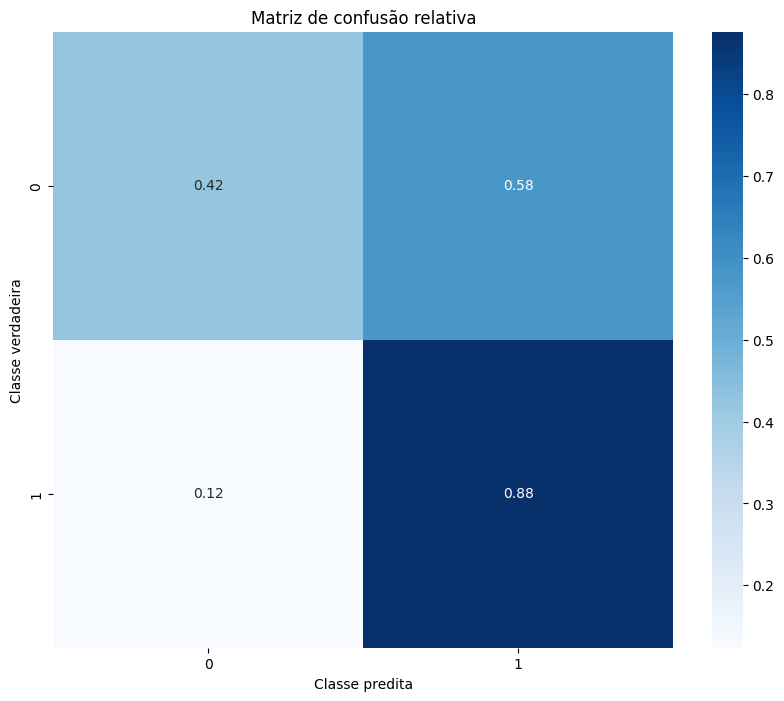

In [7]:
evaluate_metrics(y_val, p_val)

In [8]:
p_test = rndForest.predict(x_test)

In [9]:
print(metrics.classification_report(y_test, p_test))

              precision    recall  f1-score   support

           0       0.33      0.36      0.34       449
           1       0.88      0.87      0.88      2510

    accuracy                           0.79      2959
   macro avg       0.61      0.61      0.61      2959
weighted avg       0.80      0.79      0.80      2959



Accuracy: 0.793
Accuracy (balanced): 0.615


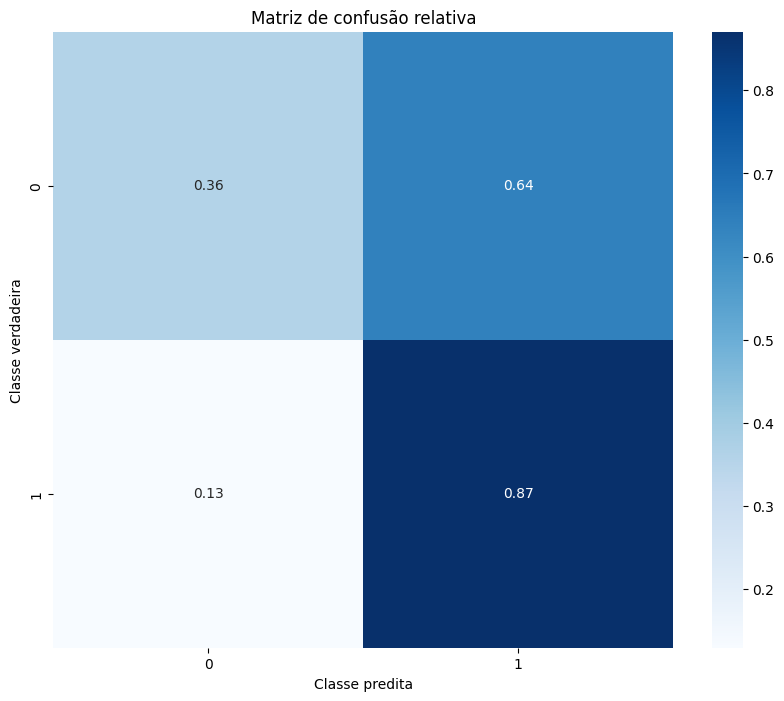

In [10]:
evaluate_metrics(y_test, p_test)